# GOES-R ABI CIMSS True Color RGB
> Using ABI Cloud and Moisture Imagery (CMI), generate True Color RGB.
- Pull CMI file from AWS
- Read B01-B03 data
- Compile RGB Composite
- Plot full disk and with cartopy projection

This notebook is part of the GOES-R DataJam 2023.

Author: Tyler C. Summers\
Email: stie311@gmail.com\
Date: 2023/09/16

In [1]:
#!/usr/bin/env python
from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray
import netCDF4 as nc
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests

In [2]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-MCMIPF'
year = 2020
day_of_year = 229
hour = 15

In [3]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [4]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [5]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}'
                  )


key = [key for key in keys][0] # selecting the first measurement taken within the hour

resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = nc.Dataset(file_name, memory = resp.content)
store = xarray.backends.NetCDF4DataStore(nc4_ds)
C = xarray.open_dataset(store)

In [6]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2020-08-16 15:00:20.600000
Scan midpoint : 2020-08-16 15:05:06
Scan End      : 2020-08-16 15:09:51.400000
File Created  : 2020-08-16 15:10:02.600000
Scan Duration : 9.50 minutes


In [7]:
# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print('{} is {:.2f} {}'.format(
        C['band_wavelength_C{:02d}'.format(band)].long_name,
        float(C['band_wavelength_C{:02d}'.format(band)][0]),
        C['band_wavelength_C{:02d}'.format(band)].units))

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [8]:
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data 
B = C['CMI_C01'].data

In [9]:
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

In [10]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

In [11]:
# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

In [12]:
# The final RGB array :)
RGB = np.dstack([R, G_true, B])

In [13]:
# x (north/south) y (east/west) radians
lat_rad_1d = C['x'].data 
lon_rad_1d = C['y'].data

In [14]:
# GOES-R projection info and retrieving relevant constants
proj_info = C['goes_imager_projection']
lon_origin = proj_info.longitude_of_projection_origin
H = proj_info.perspective_point_height+proj_info.semi_major_axis
sat_H = proj_info.perspective_point_height
r_eq = proj_info.semi_major_axis
r_pol = proj_info.semi_minor_axis

In [15]:
# close file
C.close()
C = None

In [16]:
# Define the image extent
x = lat_rad_1d * sat_H
y = lon_rad_1d * sat_H
img_extent = (x.min(), x.max(), y.min(), y.max())

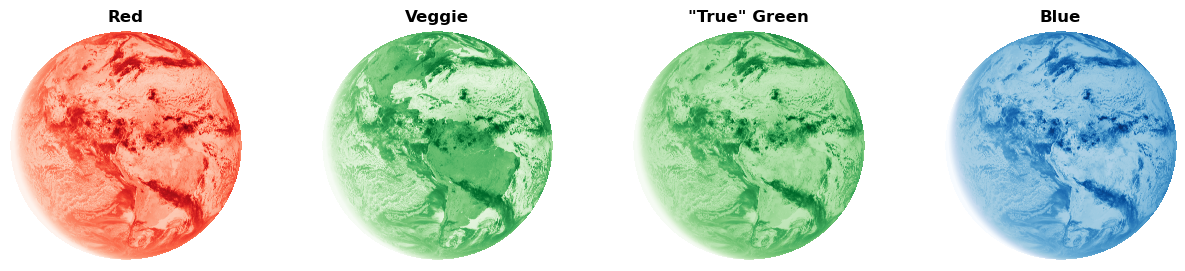

In [17]:
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='bold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Veggie', fontweight='bold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='bold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='bold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

C:\Users\stie3\anaconda3\envs\GOES_dataJam\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


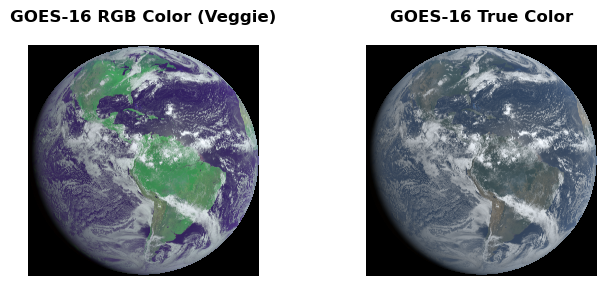

In [18]:
fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(8, 3))

ax1.imshow(np.dstack([R, G, B]), origin='upper',extent=img_extent)
ax1.set_title('GOES-16 RGB Color (Veggie)', fontweight='bold')
ax1.axis('off')

ax2.imshow(RGB, origin='upper',extent=img_extent)
ax2.set_title('GOES-16 True Color', fontweight='bold')
ax2.axis('off')

plt.show()

C:\Users\stie3\anaconda3\envs\GOES_dataJam\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


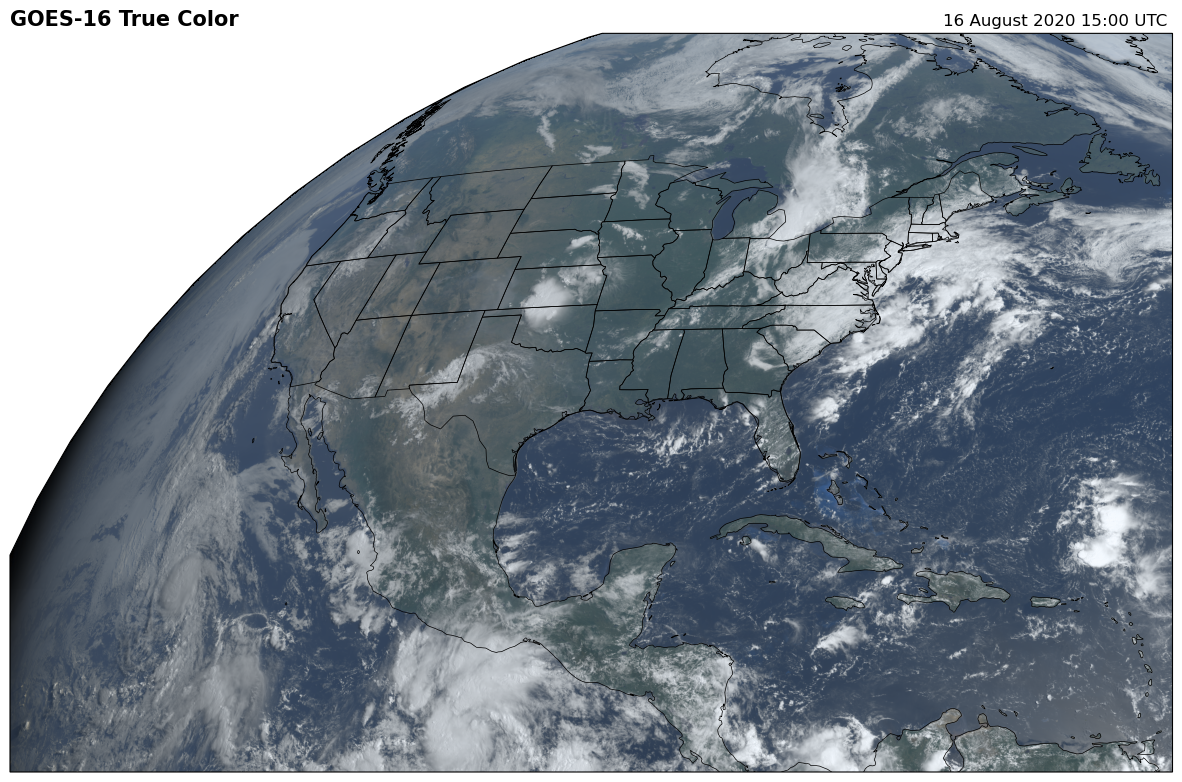

In [19]:
fig = plt.figure(figsize=(15, 12))

# Generate an Cartopy projection
geos = ccrs.Geostationary(central_longitude=lon_origin,satellite_height=sat_H)

ax = plt.axes(projection=geos)
ax.set_extent([-135, -60, 10, 65], crs=ccrs.PlateCarree())

ax.imshow(RGB, origin='upper',extent=img_extent)
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

plt.show()